## Final Project Submission

Please fill out:
* Student name: Claire Sarraille
* Student pace: self paced
* Scheduled project review date/time:  Monday June 14th 1pm PST
* Instructor name: Jeff Herman
* Project Repo URL: https://github.com/clairesarraille/mod1finproj/tree/main/dsc-mod-1-project-v2-1-online-ds-sp-000-master
* Blog post URL:


Set environment before running this script with: conda activate learn-env
Import datascience libraries:

In [1]:
# Import datascience libraries:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
import numpy as np
import seaborn as sn

# Import libraries for fetching and formatting data:
from tmdbv3api import TMDb, Discover, Movie
import os

# Import libraries for performing operations:
from math import ceil

# Load classes from tmdbv3api - a python library for The Movie Database (TMDb) API
tmdb = TMDb()
discover = Discover()
movie = Movie()

# Store my API key in my previously set environment variable as a tmdb.api_key string
priv_api_key = os.environ.get('TMDB_PRIVATE_API_KEY')
tmdb.api_key = priv_api_key


Preview of discover.discover_movies data:

I used this function to quickly scan a sub-set of titles & tweak variables such as:
- 'with_original_language': 'en'

I used a slightly different function to pretty-print samples of all info for a sub-set of movies. See appendix.

In [2]:
def print_sample_tmdb(m, m_r, p, y):
    print()
    print(f"Year is: {y}")
    print(f"Page is: {p +1}")
    print(f"There are {len(m[y])} movies in movies dict for {y}")
    for d in m_r[0:1]:
        print("sample original title: ", (dict(d))['original_title'])
    print()
    

Function to extract 500 movies each for years 2016-2021 inclusive, sorted by revenue descending
This line is commented out in the code below, to preserve space in the notebook:
- print_sample_tmdb(movies, movies_running, page, year)

In [3]:
# This function uses the discover.discover_movies() method from the tmdbv3api package to intake initial movie data:

# Define Constants
# Constants are usually defined on a module level and written in all capital letters with underscores separating words
N_YEAR_RANGE = range(2016, 2022)  # grab 2016-2021 data, inclusive
N_RESULT = 500  # Enter number of results desired for each year
N_RESULT_PAGE = 20  # Discover() class returns 20 results per page
# Num pages = Num results / num results per page, rounded UP using math.ceil
N_PAGES = ceil(N_RESULT / N_RESULT_PAGE)

# Instantiate empty dictionary movies to store outside of the following loops,
# because you want to use movies after loops are finished executing
movies = {}

# Function to grab data from discover.discover_movies:


def return_discover_movies():
    for year in N_YEAR_RANGE:  # iterate through years 2000-2019 inclusive
        # Keys are integers for each year
        # Values will be lists of tmdbv3api objects, converted to dictionaries
        movies[year] = []
        for page in range(0, N_PAGES):
            # For N_PAGES, create list movies_running, querying results by year, page, & sort revenue desc
            # The objects within movies_running 'tmdbv3api.as_obj.AsObj' objects, and will need to be converted to dictionaries later
            movies_running = discover.discover_movies({
                # We want to sort by revenue so that we make sure we're getting the highest grossing movies in each batch of 500
                'sort_by': 'revenue.desc',
                'primary_release_year': str(year),
                # API is 1 indexed - so we grab pages 1 to N_PAGES inclusive
                'page': str(page + 1),
                # Movies with 0 votes are likely among the most unpopular. OK to filter by at least 1 vote.
                'vote_count.gte': 1,
                # Since our studio is still in R&D mode, we'll focus on movies originally shot in English
                'with_original_language': 'en'
            })
            # For each year in our movies dictionary, store the year as a key (datatype list) in dictionary "movies"
            # Then, iterate through 'tmdbv3api.as_obj.AsObj' objects in movies_running for N_PAGES, converting each object as a dictionary
            # For each year we will have a list of dictionaries, and each dictionary is a set of information for a single movie
            # .extend used rather than .append in order to extend our list by >1 items at once
            movies[year].extend([dict(tmdb_obj)
                                for tmdb_obj in movies_running])

            # print_sample_tmdb(movies, movies_running, page, year)  # Preview original movie titles:


# Now we have our dictionary movies, with years 2000-2019 inclusive, each with 100 movies in each list from that year
# We didn't need to return movies in the definition of this function, because movies was declared before the function
return_discover_movies()


# Now that we've collected our 3,000 titles, sorted by descending revenue for each year, let's do some initial data exploration and cleaning:

In [4]:
# Sanity check there are 3,000 titles in movies dictionary
# Print ALL movie titles and ids from movies dictionary to qa_titles.txt for data-cleaning prep: manual review
movie_count = 0
for year in movies:
    for moo_vie in range(0, len(movies[year])):
        movie_count += 1
        my_string = f"{movies[year][moo_vie]['title']}       {movies[year][moo_vie]['id']}"
        with open("/Users/clairesarraille/git-repos/mod1finproj/dsc-mod-1-project-v2-1-online-ds-sp-000-master/qa_files/qa_titles.txt", "a+", encoding='utf-8') as file_object:
            # Move read cursor to the start of file.
            file_object.seek(0)
            data = file_object.read(100)
            if len(data) > 0:
                file_object.write("\n")
            file_object.write(my_string)

# Print movie counts in movies dict:
print("The total movie count returned from our return_discover_movies() function above is: ")
print(movie_count)

# Print keys in movies dict:
print()
print("The keys in our movies dictionary are:")
print(movies.keys())


The total movie count returned from our return_discover_movies() function above is: 
3000

The keys in our movies dictionary are:
dict_keys([2016, 2017, 2018, 2019, 2020, 2021])


While scanning the above list, I found the following that I'll use to develop some data clean-up methods:

- These don't look legitimate:
    - movie_02    813075
    - movie_01    813064
    - welcome_home.exe    82418
    - jji    763071

- There's a double entry for this movie:
    - Split    358364
    - Split    381288

- Not in English, this one I later caught when running the analysis to find non-ascii characters:
    - عتيج    676624


In [5]:
# Upon internet research and cross-referencing I found that they're all legitimate movies. Nice!

likely_suspects = [813075,813064,824186,763071,358364,381288]

for suspect in likely_suspects:
    m = movie.details(suspect)   
    print(m.title)
    print(m.id)
    print(m.release_date)
    print(m.overview)
    print(m.popularity)
    print()


movie_02
813075
2021-04-02
An experimental short shot in March of 2021.
0.629

movie_01
813064
2021-03-24
An experimental short shot over summer 2020.
0.6

welcome_home.exe
824186
2021-04-29
As technology accelerates, our species' collective imagination of the future grows ever more kaleidoscopic. We are all haunted by temporal distortion, perhaps no more than when we attempt to remember what the future looked like to our younger selves. As the mist of time devours our memories, the future recedes; each of us burdened by the gaping mouth of entropy. Yet, emerging technology provides a glimmer of hope; transhumanism promises a future free from mortality, disease and pain. Does our salvation lie in digital simulacra? We're here to sell you the answer to that question, for the low, low price of four hundred and seventy seconds.
1.036

jji
763071
2019-04-19
the summer breathes.
0.6

Split
358364
2016-04-07
The story of a young woman who takes an epic journey to claim her own darkness and s

In [6]:
# Check that API is working properly by spot-checking movie titles/ids between methods discover.discover_movies and movie.details()

# Expected data (from discover.movies)
# Bigfoot vs the Illuminati
# 784281
my_result = movie.details(784281)
print(my_result.title)
print(my_result.id)
print()

# Expected data (from discover.movies)
# Cheez-It's & Chili
# 802103
my_result = movie.details(802103)
print(my_result.title)
print(my_result.id)
print()

# Expected data (from discover.movies)
# A Tiny House Christmas
# 796438
my_result = movie.details(796438)
print(my_result.title)
print(my_result.id)
print()


Bigfoot vs the Illuminati
784281

Cheez-It's & Chili
802103

A Tiny House Christmas
796438



Our movies dictionary has keys for years 2016-2021
The value for each year is a list of dictionaries. Each dictionary is a movie.
To turn this data into a Pandas datastructure, we iterate through all the years and all the dictionaries in each year
Our result, movies_list_of_dict is a simple list of all the movie dictionaries.
All we have to do then is use pd.DataFrame() to use the keys as column headers and the values as the cell values in rows.

In [7]:
movies_list_of_dict = [movie_d for movie_yr in movies for movie_d in movies[movie_yr]]
df_movies = pd.DataFrame(movies_list_of_dict)


In [8]:
# Preview df_movies:
# First three movies:
df_movies.head(3)


,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,False,/kvRT3GwcnqGHzPjXIVrVPhUix7Z.jpg,"[12, 28, 878]",271110,en,Captain America: Civil War,"Following the events of Age of Ultron, the col...",76.041,/rAGiXaUfPzY7CDEyNKUofk3Kw2e.jpg,2016-04-27,Captain America: Civil War,False,7.4,18140
1,False,/6t8ES1d12OzWyCGxBeDYLHoaDrT.jpg,"[28, 12, 878]",330459,en,Rogue One: A Star Wars Story,A rogue band of resistance fighters unite for ...,40.555,/5jX3p0apUG5bkMHtnKZch0xpkBS.jpg,2016-12-14,Rogue One: A Star Wars Story,False,7.5,12143
2,False,/wijltj1toRcicHlCn8Cpsp4yPXe.jpg,"[12, 16, 35, 10751]",127380,en,Finding Dory,Dory is reunited with her friends Nemo and Mar...,28.991,/3UVe8NL1E2ZdUZ9EDlKGJY5UzE.jpg,2016-06-16,Finding Dory,False,7.0,9920


In [9]:
# Last three movies:
df_movies.tail(3)


,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
2997,False,/5HnRbS5pYg588vqNBSsV2VlbMDf.jpg,[28],797208,en,UFC Fight Night 186: Rozenstruik vs. Gane,UFC Fight Night Rozenstruik vs. Gane,1.454,/f7sF9OwxT7QOVbNMlwcHNmMv8f1.jpg,2021-02-27,UFC Fight Night 186: Rozenstruik vs. Gane,False,10.0,1
2998,False,None,[27],797173,en,I C U,A boy browses a livestream website.,0.691,/fzArv7YQ570J2nK94A8fBIkPT1r.jpg,2021-02-14,I C U,False,10.0,1
2999,False,None,[53],797071,en,RAGE,After a violent home invasion leaves him in a ...,2.282,/w8CGob5vk8mAJqR2j5FAMDuruWB.jpg,2021-02-22,RAGE,False,5.5,2


In [10]:
# See number of rows and columns, respectively:
df_movies.shape


(3000, 14)

Are there any null values?
It looks like the only null values are for backdrop_path (suffix for movie's image URL)
In other words, no missing data for this analysis so far.

In [11]:
df_movies.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   adult              3000 non-null   bool   
 1   backdrop_path      1934 non-null   object 
 2   genre_ids          3000 non-null   object 
 3   id                 3000 non-null   int64  
 4   original_language  3000 non-null   object 
 5   original_title     3000 non-null   object 
 6   overview           3000 non-null   object 
 7   popularity         3000 non-null   float64
 8   poster_path        2843 non-null   object 
 9   release_date       3000 non-null   object 
 10  title              3000 non-null   object 
 11  video              3000 non-null   bool   
 12  vote_average       3000 non-null   float64
 13  vote_count         3000 non-null   int64  
dtypes: bool(2), float64(2), int64(2), object(8)
memory usage: 287.2+ KB


Just for fun, let's explore one movie's backdrop_path - what would we do with this field?
One of my favorite movies from the past 6 years is Get Out - so lets find it in df_movies
I accessed a subset of df_movies with .loc using a pandas series of boolean values (title contains 'Get Out')

In [12]:
get_out = df_movies[['title', 'backdrop_path']].loc[(df_movies['title'].str.contains('Get Out'))]
get_out


,title,backdrop_path
531,Get Out,/vZ7EVk7FaNEWYqlVWbFLHP8Z0LU.jpg


According to the TMDb API documentation, the backdrop_path is the ```file_path``` one uses in conjunction with a ```base_url``` and ```file_size``` to generate an image URL.  Here's the backdrop_bath for Get Out appended to https://image.tmdb.org/t/p/w500/ to retrieve the w500 size:
- https://image.tmdb.org/t/p/w500/vZ7EVk7FaNEWYqlVWbFLHP8Z0LU.jpg


- I embedded it here by using <img src="get_out.png"\>, and storing the png version of the image in the same folder with this notebook.

<img src="get_out.png">

That was fun! But we must move on. Next we'll take the movies we've already gathered, which are sorted by descending revenue for years 2016-2021, and grab more details for each movie from TMDb's movie details resource. That way, we can grab the fields we need to conduct later analysis and visualization: revenue, budget, keywords, genres, and production companies.
# Our next task is to use the method movies.details() to get the columns we want for our 3,000 titles

In [13]:
# Next, we'll create a list of movie ids we have stored in df_movies
# We'll use that list to get more detailed movie info from the tmdbv3api library's movie.details() method

# Create list of movie ids from df_movies:
movie_id_list = df_movies['id'].tolist()

# Check length of list:
len(movie_id_list)


3000

The following finds any movies that would throw an error when passed to movie.details()
It also ensures we're passing field values that exist from movie.details()
Under the hood of the tmdbv3api library we are simply using the GET method to retrieve data from the TMDb server at a specified resource.
The TMDb API behaves such that if the movie id doesn't exist in the /movie/{movie_id} resource, we'll get an error back
Let's see if any of our movie ids would throw such an error:

In [14]:
my_keys = ['id', 'title', 'release_date', 'revenue', 'budget', 'genres', 'original_language',
           'spoken_languages', 'popularity', 'production_companies', 'production_countries', 'runtime', 'keywords']

details_list = []

for id_index in movie_id_list: # For each movie id in movie_id_list, we try to get results back from movie.details(), if not, the movie id is printed
    try:
        r = movie.details(id_index)
        details_list.extend({my_key: dict(r).get(my_key)
                            for my_key in my_keys})
    except:
        print(id_index)
        continue


781739


In [15]:
# Out of curiosity, lets look at the details for this movie:
df_movies[['title', 'id', 'popularity', 'overview',
           'release_date']].loc[(df_movies['id'] == 781739)]


,title,id,popularity,overview,release_date
2397,Hero,781739,0.0,Hero was diagnosed with cancer at the age of 2...,2020-12-31


In [16]:
# To identify the movie lets look at the overview more closely:
print(df_movies.loc[(df_movies['id'] == 781739), 'overview'].item())


Hero was diagnosed with cancer at the age of 22. After losing faith in himself, and getting ready to give up, he found support in a place he felt safe - The Furry Fandom. Now, Hero is getting his first fursuit. This is his story.


This turned out to be a touching documentary, and one that seems to have received a decent amount of attention, but we won't be worried about not having it in our dataset. We'll remove it from movie_id_list and re-run our error-catching code.

In [17]:
# Remove movie id from list:
movie_id_list.remove(781739)


In [18]:
# Re-run error-catching code
# Returns 0 movie ids - nice!
my_keys = ['id', 'title', 'release_date', 'revenue', 'budget', 'genres', 'original_language',
           'spoken_languages', 'popularity', 'production_companies', 'production_countries', 'runtime', 'keywords']

details_list = []

for id_index in movie_id_list:
    try:
        # movie.details() returns a tmdb object, NOT a dictionary.
        r = movie.details(id_index)
        # Extend details_list by a dictionary for each movie, where each movie dictionary contains all key-value pairs for my_keys
        details_list.extend({my_key: dict(r).get(my_key)  # the tmdb object r must be converted to a dictionary to get the value for each of my keys
                            for my_key in my_keys})
    except:
        print(id_index)
        continue


Finally, we can retrieve the data we want from movie.details()!
A way I dealt with any anticipated missing fields for each movie:
In case any of the movies are missing any of the below keys, I used dict.get(), which returns None instead of throwing an error if a given key doesn't exist

In [19]:
my_keys = ['id', 'title', 'release_date', 'revenue', 'budget', 'genres', 'original_language',
           'spoken_languages', 'popularity', 'production_companies', 'production_countries', 'runtime', 'keywords']

details_list = []
details_list.extend({my_key: dict(movie.details(id_index)).get(my_key)
                    for my_key in my_keys} for id_index in movie_id_list)

print(details_list[0])  # Preview the first movie dictionary in our list!


{'id': 271110, 'title': 'Captain America: Civil War', 'release_date': '2016-04-27', 'revenue': 1153296293, 'budget': 250000000, 'genres': [{'id': 12, 'name': 'Adventure'}, {'id': 28, 'name': 'Action'}, {'id': 878, 'name': 'Science Fiction'}], 'original_language': 'en', 'spoken_languages': [{'english_name': 'Romanian', 'iso_639_1': 'ro', 'name': 'Română'}, {'english_name': 'English', 'iso_639_1': 'en', 'name': 'English'}, {'english_name': 'German', 'iso_639_1': 'de', 'name': 'Deutsch'}, {'english_name': 'Russian', 'iso_639_1': 'ru', 'name': 'Pусский'}], 'popularity': 80.546, 'production_companies': [{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZxCGEKTXaQ.png', 'name': 'Marvel Studios', 'origin_country': 'US'}], 'production_countries': [{'iso_3166_1': 'US', 'name': 'United States of America'}], 'runtime': 147, 'keywords': {'keywords': [{'id': 393, 'name': 'civil war'}, {'id': 9663, 'name': 'sequel'}, {'id': 9715, 'name': 'superhero'}, {'id': 9717, 'name': 'based on comic'}, {'id': 179430,

In [20]:
# Now we take this list of dictionaries and easily convert it to a pandas dataframe df_details:
df_details = pd.DataFrame(details_list)
df_details[0:3] # Preview the first three movies


,id,title,release_date,revenue,budget,genres,original_language,spoken_languages,popularity,production_companies,production_countries,runtime,keywords
0,271110,Captain America: Civil War,2016-04-27,1153296293,250000000,"[[id, name], [id, name], [id, name]]",en,"[[english_name, iso_639_1, name], [english_nam...",80.546,"[[id, logo_path, name, origin_country]]","[[iso_3166_1, name]]",147.0,[keywords]
1,330459,Rogue One: A Star Wars Story,2016-12-14,1056057273,200000000,"[[id, name], [id, name], [id, name]]",en,"[[english_name, iso_639_1, name]]",37.223,"[[id, logo_path, name, origin_country]]","[[iso_3166_1, name]]",133.0,[keywords]
2,127380,Finding Dory,2016-06-16,1028570889,200000000,"[[id, name], [id, name], [id, name], [id, name]]",en,"[[english_name, iso_639_1, name]]",36.533,"[[id, logo_path, name, origin_country]]","[[iso_3166_1, name]]",97.0,[keywords]


# We finally have the data we want stored in df_details.

# Take a look at big-picture of df_details
It makes sense that we have 2999 entries since we removed the movie Hero.
It looks like we have one null value for run-time

In [21]:
df_details.index
df_details.info()
df_details.columns
df_details.dtypes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    2999 non-null   int64  
 1   title                 2999 non-null   object 
 2   release_date          2999 non-null   object 
 3   revenue               2999 non-null   int64  
 4   budget                2999 non-null   int64  
 5   genres                2999 non-null   object 
 6   original_language     2999 non-null   object 
 7   spoken_languages      2999 non-null   object 
 8   popularity            2999 non-null   float64
 9   production_companies  2999 non-null   object 
 10  production_countries  2999 non-null   object 
 11  runtime               2998 non-null   float64
 12  keywords              2999 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 304.7+ KB


id                        int64
title                    object
release_date             object
revenue                   int64
budget                    int64
genres                   object
original_language        object
spoken_languages         object
popularity              float64
production_companies     object
production_countries     object
runtime                 float64
keywords                 object
dtype: object

# My first data-cleaning task was to detect any movies not originally shot in English
- Since our studio is still in R&D mode, we'll focus on movies originally shot in English
- 'with_original_language' was already set to 'en' upon intake, but this next step helps find foreign language films that slipped through


In [22]:
# Detect non-english strings in title and remove them from df_details:

pd.set_option('display.max_rows', df_details.shape[0]+1) # Set display option so that we can see all rows because we will likely manually review the values:

# Create function to detect non-english strings:
def detect_en(ascii_string):
    try:
        ascii_string.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

column_names = ["id", "title"]
flag_non_en = pd.DataFrame(columns = column_names)
for item in df_details.loc[:, 'title']:
    if detect_en(item) == False:
        flag_non_en = flag_non_en.append(df_details[['id','title']].loc[df_details['title'] == item])
print(flag_non_en.iloc[8:14]) # Sample rows 8-14 for illustration purposes


         id                  title
440  676624                   عتيج
467  671272  Óleos en la oscuridad
468  670997      A nuestros héroes
477  664648              Crisálida
499  645535      Alice in the Café
783  400768          Killer Piñata


I made a list of the movies I wanted to remove from df_details, based on internet research to see if original language is English.

- 720980      Express Yourself: Die Tänzer der Queen of Pop
- 676624                                               عتيج
- 671272                              Óleos en la oscuridad
- 664648                                          Crisálida
- 692856                                              Avīci
- 691836                      Avante (Ao Vivo em São Paulo)
- 680817                                      Hranice práce
- 676912                                            Sátiros
- 703348                                               عقلي
- 720570                                   maníaco da ponte
- 832125                                  Ghostemane: Ímpio
- 806831                 História Secreta do Pop Brasileiro
- 783999        Crimes de haine en Amérique : l'inquiétante
- 740354                                          Bach-Hông
- 793311                                   Toilette d’amour
- 787619                                           Czyściec
- 832310                                           Verrückt
- 822161                                         ¿Libertad?
- 802434                                              Acéré

In [23]:
# Remove rows with these ids from df_details:
non_eng_ids = [720980, 676624, 671272, 664648, 692856, 691836, 680817, 676912, 703348, 720570, 832125, 806831, 783999, 740354, 793311, 787619, 832310, 822161, 802434]

# Remove movie id from list:
df_details = df_details[~df_details['id'].isin(non_eng_ids)]


In [24]:
# Check to make sure they're no longer in there:
df_details[df_details['id'].isin(non_eng_ids)]

,id,title,release_date,revenue,budget,genres,original_language,spoken_languages,popularity,production_companies,production_countries,runtime,keywords


In [25]:
# Spot-check a single id:
df_details.loc[(
    df_details['id'] == 671272)]


,id,title,release_date,revenue,budget,genres,original_language,spoken_languages,popularity,production_companies,production_countries,runtime,keywords


# The next data cleaning step was to convert the date field from str to datetime64
A lot of the fields we got back are objects.
Lets make sure that release_date is an object we can work with
We'll use the first movie in our list as an example:
271110	Captain America: Civil War

In [26]:
capt_amer_date = df_details.loc[(
    df_details['id'] == 271110), 'release_date'].item()
print(type(capt_amer_date))
print(capt_amer_date)


<class 'str'>
2016-04-27


Since it's a string, lets convert it to dtype ```datetime64[ns]``` which is built on the NumPy ```datetime64``` dtype

In [27]:
df_details['release_date'] = pd.to_datetime(df_details['release_date'])

capt_amer_date = df_details.loc[(
    df_details['id'] == 271110), 'release_date'].item()
print(type(capt_amer_date))
print(capt_amer_date)


<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2016-04-27 00:00:00


# The final data cleaning step was to convert fields that are lists of objects to more simple datastructures:
I'll need to convert any field that I want to use in a visualization into a useable format. Let's start with genres!

In [28]:
# Preview the genres column, dtype object
my_sample = df_details.loc[0:2, 'genres']
type(my_sample)
my_sample
for mystery in my_sample:
    print(type(mystery))
    print(type(mystery[0]))
    print(mystery)


<class 'list'>
<class 'tmdbv3api.as_obj.AsObj'>
[{'id': 12, 'name': 'Adventure'}, {'id': 28, 'name': 'Action'}, {'id': 878, 'name': 'Science Fiction'}]
<class 'list'>
<class 'tmdbv3api.as_obj.AsObj'>
[{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 878, 'name': 'Science Fiction'}]
<class 'list'>
<class 'tmdbv3api.as_obj.AsObj'>
[{'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]


In [29]:
# Convert these lists of objects to lists of dictionaries using .apply() to map each genre value
def convert_to_list_of_dict(val):
    # val parameter is used to transform each value of the pandas genres series
    val = [dict(x) for x in val]
    return val


df_details['genres_list_dict'] = df_details.loc[:,
                                                'genres'].apply(convert_to_list_of_dict)
                                                

In [30]:
my_sample = df_details.loc[0:2, 'genres_list_dict']
for mystery in my_sample:
    print(type(mystery))
    print(type(mystery[0]))
    print(mystery)


<class 'list'>
<class 'dict'>
[{'id': 12, 'name': 'Adventure'}, {'id': 28, 'name': 'Action'}, {'id': 878, 'name': 'Science Fiction'}]
<class 'list'>
<class 'dict'>
[{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 878, 'name': 'Science Fiction'}]
<class 'list'>
<class 'dict'>
[{'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]


In [31]:
# Preview our new column "genres_list_dict"
df_details['genres_list_dict'][0]

[{'id': 12, 'name': 'Adventure'},
 {'id': 28, 'name': 'Action'},
 {'id': 878, 'name': 'Science Fiction'}]

In [32]:
# Convert lists of dictionaries to a list of strings, where each string is the name of a genre
def convert_to_list_of_str(val):
    # val parameter is used to transform each value of the pandas genres series
    val = [x.get('name') for x in val]
    return val


df_details['genres_list_str'] = df_details.loc[:,
                                                'genres_list_dict'].apply(convert_to_list_of_str)
                                                

In [33]:
my_sample = df_details.loc[0:2, 'genres_list_str']
for mystery in my_sample:
    print(type(mystery))
    print(type(mystery[0]))
    print(mystery)


<class 'list'>
<class 'str'>
['Adventure', 'Action', 'Science Fiction']
<class 'list'>
<class 'str'>
['Action', 'Adventure', 'Science Fiction']
<class 'list'>
<class 'str'>
['Adventure', 'Animation', 'Comedy', 'Family']


In [34]:
# Preview the results:
df_details[['title', 'genres_list_str']].iloc[400:403]

,title,genres_list_str
401,The Last Appeal,"[Drama, TV Movie]"
402,Cinema Self,[]
403,Farewell Boleyn,[Documentary]


In [ ]:
# Remove any rows where there are 0 genres:
df_details = df_details[~df_details['id'].isin(non_eng_ids)]


# Convert empty genre lists in genre column to NaN, then remove those rows:


In [35]:
# Rather than empty lists, I want movies with no genre to be the numpy null value, which is NaN:
import numpy as np
df_details['genres_list_str'] = df_details['genres_list_str'].apply(
    lambda x: np.nan if len(x) == 0 else x)


In [36]:
# Check that it worked:
is_NaN = df_details.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_details[row_has_NaN]

rows_with_NaN[['title', 'genres','genres_list_str']].iloc[0:3]


,title,genres,genres_list_str
276,The Girl on the Mat,[],NaN
302,First Day Out,[],NaN
303,Wild Flowers,[],NaN


In [39]:
# Drop any rows where genres_list_str is NaN:
df_details.dropna(subset = ["genres_list_str"], inplace=True)


In [44]:
# Check that there are no NaN values in genres_list_str:
df_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2541 entries, 0 to 2998
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    2541 non-null   int64         
 1   title                 2541 non-null   object        
 2   release_date          2541 non-null   datetime64[ns]
 3   revenue               2541 non-null   int64         
 4   budget                2541 non-null   int64         
 5   genres                2541 non-null   object        
 6   original_language     2541 non-null   object        
 7   spoken_languages      2541 non-null   object        
 8   popularity            2541 non-null   float64       
 9   production_companies  2541 non-null   object        
 10  production_countries  2541 non-null   object        
 11  runtime               2540 non-null   float64       
 12  keywords              2541 non-null   object        
 13  genres_list_dict  

# Now we're going to do the same thing for production_companies - it has the same structure as genres:

In [46]:
my_sample = df_details.loc[0:2, 'production_companies']
for mystery in my_sample:
    print(type(mystery))
    print(type(mystery[0]))
    print(mystery)

<class 'list'>
<class 'tmdbv3api.as_obj.AsObj'>
[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZxCGEKTXaQ.png', 'name': 'Marvel Studios', 'origin_country': 'US'}]
<class 'list'>
<class 'tmdbv3api.as_obj.AsObj'>
[{'id': 1, 'logo_path': '/o86DbpburjxrqAzEDhXZcyE8pDb.png', 'name': 'Lucasfilm Ltd.', 'origin_country': 'US'}]
<class 'list'>
<class 'tmdbv3api.as_obj.AsObj'>
[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUHpPEwLf7.png', 'name': 'Pixar', 'origin_country': 'US'}]


In [62]:
def convert_to_list_of_dict(val):
    val = [dict(x) for x in val]
    return val


df_details['prod_list_dict'] = df_details.loc[:,'production_companies'].apply(convert_to_list_of_dict)
                                                

In [63]:
my_sample = df_details.loc[0:2, 'prod_list_dict']
for mystery in my_sample:
    print(type(mystery))
    print(type(mystery[0]))
    print(mystery)


<class 'list'>
<class 'dict'>
[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZxCGEKTXaQ.png', 'name': 'Marvel Studios', 'origin_country': 'US'}]
<class 'list'>
<class 'dict'>
[{'id': 1, 'logo_path': '/o86DbpburjxrqAzEDhXZcyE8pDb.png', 'name': 'Lucasfilm Ltd.', 'origin_country': 'US'}]
<class 'list'>
<class 'dict'>
[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUHpPEwLf7.png', 'name': 'Pixar', 'origin_country': 'US'}]


In [64]:
# Preview our new column "prod_list_dict"
df_details['prod_list_dict'][0]

[{'id': 420,
  'logo_path': '/hUzeosd33nzE5MCNsZxCGEKTXaQ.png',
  'name': 'Marvel Studios',
  'origin_country': 'US'}]

In [65]:
def convert_to_list_of_str(val):
    val = [x.get('name') for x in val]
    return val


df_details['prod_list_str'] = df_details.loc[:,
                                                'prod_list_dict'].apply(convert_to_list_of_str)
                                                

In [66]:
my_sample = df_details.loc[0:2, 'prod_list_str']
for mystery in my_sample:
    if len(mystery) == 0:
        print(mystery)


In [67]:
# Make empty lists NaN:
import numpy as np
df_details['prod_list_nan'] = df_details['prod_list_str'].apply(
    lambda x: np.nan if len(x) == 0 else x)

In [69]:
# Check that it worked:
is_NaN = df_details.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_details[row_has_NaN]

rows_with_NaN[['title', 'genres_list_str','prod_list_nan']].iloc[0:3]

,title,genres_list_str,prod_list_nan
31,Split,"[Fantasy, Drama, Thriller, Crime]",NaN
201,Hillsong: Let Hope Rise,[Documentary],NaN
228,Lulu the Movie,[Comedy],NaN


In [72]:
# Drop any rows where prod_list_str is NaN:

df_details.dropna(subset = ["prod_list_nan"], inplace=True)


In [73]:
# Check that there are no NaN values in genres_list_str:
df_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1889 entries, 0 to 2996
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    1889 non-null   int64         
 1   title                 1889 non-null   object        
 2   release_date          1889 non-null   datetime64[ns]
 3   revenue               1889 non-null   int64         
 4   budget                1889 non-null   int64         
 5   genres                1889 non-null   object        
 6   original_language     1889 non-null   object        
 7   spoken_languages      1889 non-null   object        
 8   popularity            1889 non-null   float64       
 9   production_companies  1889 non-null   object        
 10  production_countries  1889 non-null   object        
 11  runtime               1889 non-null   float64       
 12  keywords              1889 non-null   object        
 13  genres_list_dict  

In [74]:
# Preview our data, which now contains NO empty lists for genre or production company:
df_details[['id', 'title', 'release_date', 'revenue', 'budget',
                 'genres_list_str', 'popularity', 'prod_list_str', 'runtime']].iloc[60:70]


,id,title,release_date,revenue,budget,genres_list_str,popularity,prod_list_str,runtime
61,323675,Ride Along 2,2016-01-14,124827316,40000000,"[Action, Comedy]",20.653,"[Reel Chefs Catering, Universal Pictures, Will...",102.0
62,296524,Deepwater Horizon,2016-09-29,121790373,110000000,"[Drama, Action]",29.517,"[TIK Film, Summit Entertainment, Participant, ...",107.0
63,369885,Allied,2016-11-17,119520023,85000000,"[Action, Drama, War, Romance, Thriller]",25.508,"[Paramount, GK Films, ImageMovers, Huahua Media]",124.0
64,332567,The Shallows,2016-06-24,119100758,17000000,"[Horror, Drama, Thriller]",39.275,"[Columbia Pictures, Ombra Films, Weimaraner Re...",86.0
65,316727,The Purge: Election Year,2016-06-29,118587880,10000000,"[Action, Horror, Thriller]",71.745,"[Why Not Productions, Universal Pictures, Blum...",105.0
66,356305,Why Him?,2016-12-22,118102725,38000000,[Comedy],18.913,"[21 Laps Entertainment, TSG Entertainment, 20t...",111.0
67,384682,Office Christmas Party,2016-11-25,114501299,45000000,[Comedy],9.362,"[Bluegrass Films, Entertainment 360]",105.0
68,259694,How to Be Single,2016-01-21,112343513,38000000,"[Comedy, Romance]",23.788,"[New Line Cinema, Metro-Goldwyn-Mayer, Flower ...",110.0
69,299687,The 5th Wave,2016-01-14,109906372,38000000,"[Science Fiction, Adventure, Action]",34.548,"[LStar Capital, Columbia Pictures, GK Films, M...",112.0
70,325133,Neighbors 2: Sorority Rising,2016-05-04,108758521,35000000,[Comedy],20.812,"[Perfect World Pictures, Point Grey Pictures, ...",92.0


# Finally, I created a dataframe with only the columns I wanted to keep:

In [269]:
# Keep these Columns:
df = df_details[['id', 'title', 'release_date', 'revenue', 'budget',
                 'genres_list_str', 'popularity', 'prod_list_str', 'runtime']].copy()


In [270]:
df.head()

,id,title,release_date,revenue,budget,genres_list_str,popularity,prod_list_str,runtime
0,271110,Captain America: Civil War,2016-04-27,1153296293,250000000,"[Adventure, Action, Science Fiction]",80.546,[Marvel Studios],147.0
1,330459,Rogue One: A Star Wars Story,2016-12-14,1056057273,200000000,"[Action, Adventure, Science Fiction]",37.223,[Lucasfilm Ltd.],133.0
2,127380,Finding Dory,2016-06-16,1028570889,200000000,"[Adventure, Animation, Comedy, Family]",36.533,[Pixar],97.0
3,269149,Zootopia,2016-02-11,1023784195,150000000,"[Animation, Adventure, Family, Comedy]",62.448,"[Walt Disney Animation Studios, Walt Disney Pi...",109.0
4,278927,The Jungle Book,2016-04-07,966550600,175000000,"[Family, Adventure, Drama, Fantasy]",37.349,"[Walt Disney Pictures, Fairview Entertainment,...",106.0


In [271]:
# Rename genres and production companies columns:
df.rename(columns={'genres_list_str': 'genre', 'prod_list_str': 'production_company'}, inplace=True)


In [272]:
df.reset_index(inplace = True)

In [273]:
df.index
df.info()
df.columns
df.dtypes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               1889 non-null   int64         
 1   id                  1889 non-null   int64         
 2   title               1889 non-null   object        
 3   release_date        1889 non-null   datetime64[ns]
 4   revenue             1889 non-null   int64         
 5   budget              1889 non-null   int64         
 6   genre               1889 non-null   object        
 7   popularity          1889 non-null   float64       
 8   production_company  1889 non-null   object        
 9   runtime             1889 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 147.7+ KB


index                          int64
id                             int64
title                         object
release_date          datetime64[ns]
revenue                        int64
budget                         int64
genre                         object
popularity                   float64
production_company            object
runtime                      float64
dtype: object

# Next Up, Visualizations!
#  First, I created a profit column = revenue - budget

In [274]:
df['profit'] = df['revenue'] - df['budget']


In [275]:
# Get some statistics on revenue:
df[['revenue','budget','profit','popularity','runtime']].describe()


,revenue,budget,profit,popularity,runtime
count,1.889000e+03,1.889000e+03,1.889000e+03,1889.000000,1889.000000
mean,6.082077e+07,1.847793e+07,4.234285e+07,42.758138,82.031233
std,1.882482e+08,4.266326e+07,1.561850e+08,245.617415,43.430633
min,0.000000e+00,0.000000e+00,-1.510000e+08,0.600000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.895000,60.000000
50%,3.097760e+05,0.000000e+00,2.621000e+03,8.604000,94.000000
75%,2.480413e+07,1.500000e+07,9.289990e+06,22.974000,109.000000
max,2.797801e+09,3.560000e+08,2.441801e+09,5771.292000,480.000000


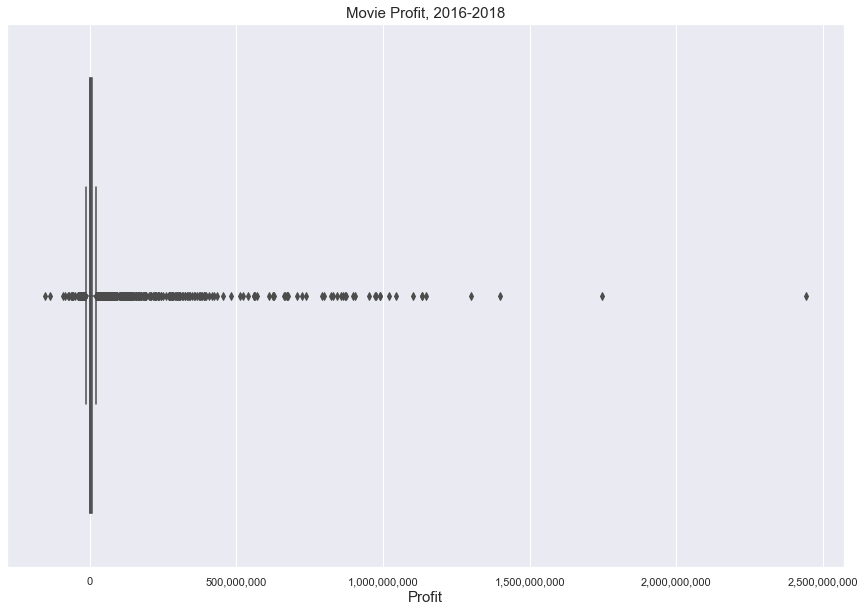

In [295]:
# Quick Boxplot to Visualize Profit Range for All Movies:
fig, ax = plt.subplots(figsize = (15,10))

sn.boxplot(data=df, x='profit')
ax.set_title('Movie Profit, 2016-2018', fontsize=15.0)
ax.set_xlabel('Profit', fontsize=15.0)
ax.ticklabel_format(style='sci', axis='x', scilimits=(1,1))

ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

# Looks like most of the movies in our dataset make next to nothing. 
# Let's do the same boxplot for Upper Quartile profit movies:

In [277]:
# Create separate df where revenue is above the Third Quartile (Q3), that is, 75% of the data falls below this percentile:
df_q3 = df[(df['revenue'] >= 9289990)].copy()


In [278]:
df_q3.reset_index(inplace = True)
df_q3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   level_0             607 non-null    int64         
 1   index               607 non-null    int64         
 2   id                  607 non-null    int64         
 3   title               607 non-null    object        
 4   release_date        607 non-null    datetime64[ns]
 5   revenue             607 non-null    int64         
 6   budget              607 non-null    int64         
 7   genre               607 non-null    object        
 8   popularity          607 non-null    float64       
 9   production_company  607 non-null    object        
 10  runtime             607 non-null    float64       
 11  profit              607 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 57.0+ KB


In [279]:
df_q3[['title','release_date','revenue', 'budget', 'profit']].head(10).style.format({"profit" : "${:20,.0f}"})


,title,release_date,revenue,budget,profit
0,Captain America: Civil War,2016-04-27 00:00:00,1153296293,250000000,"$ 903,296,293"
1,Rogue One: A Star Wars Story,2016-12-14 00:00:00,1056057273,200000000,"$ 856,057,273"
2,Finding Dory,2016-06-16 00:00:00,1028570889,200000000,"$ 828,570,889"
3,Zootopia,2016-02-11 00:00:00,1023784195,150000000,"$ 873,784,195"
4,The Jungle Book,2016-04-07 00:00:00,966550600,175000000,"$ 791,550,600"
5,The Secret Life of Pets,2016-06-18 00:00:00,875457937,75000000,"$ 800,457,937"
6,Batman v Superman: Dawn of Justice,2016-03-23 00:00:00,873634919,250000000,"$ 623,634,919"
7,Fantastic Beasts and Where to Find Them,2016-11-16 00:00:00,809342332,180000000,"$ 629,342,332"
8,Deadpool,2016-02-09 00:00:00,783100000,58000000,"$ 725,100,000"
9,Suicide Squad,2016-08-03 00:00:00,746846894,175000000,"$ 571,846,894"


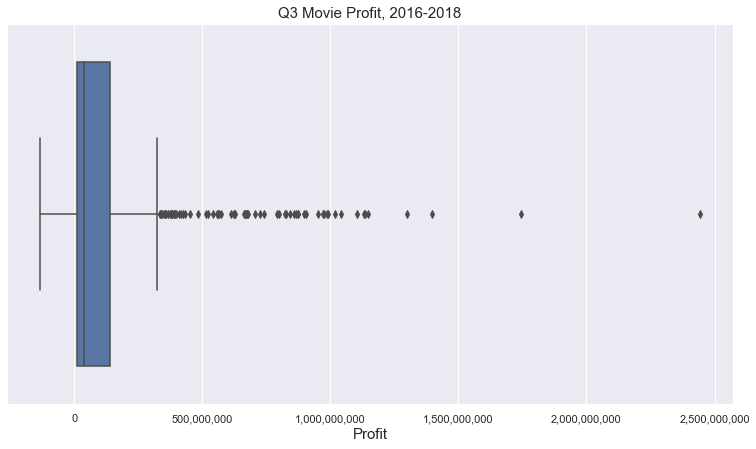

In [296]:
# Quick Boxplot to Visualize Profit Range for Q3 Movies:
fig, ax = plt.subplots(figsize = (13,7))


sn.boxplot(data=df_q3, x='profit')
ax.set_title('Q3 Movie Profit, 2016-2018', fontsize=15.0)
ax.set_xlabel('Profit', fontsize=15.0)
ax.ticklabel_format(style='sci', axis='x', scilimits=(1,1))

ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))


# Does Popularity Score from TMDb Correlate with Profit?

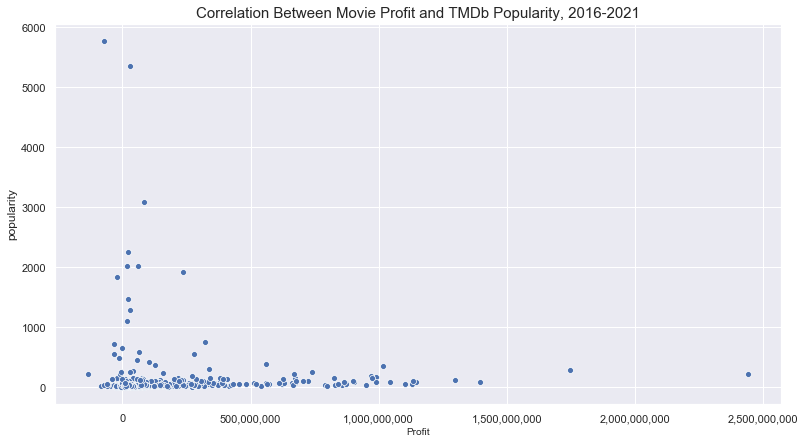

In [305]:
# It doesn't appear that profit and TMDb popularity are highly correlated:

fig, ax = plt.subplots(figsize = (13,7))

sn.scatterplot(data = df_q3, x = "profit", y = "popularity")

ax.set_title('Correlation Between Movie Profit and TMDb Popularity, 2016-2021', fontsize=15.0)
ax.set_xlabel('Profit', fontsize=10.0)

ax.ticklabel_format(style='sci', axis='x', scilimits=(1,1))

ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))



In [290]:
# We calculate the Pearson correlation coefficient and see that profit and TMDb popularity are moderately correlated:
column_1 = df["popularity"]
column_2 = df["profit"]
correlation = column_1.corr(column_2)
correlation

0.06094472170699174

# Visualize Frequency and Co-Occurence of Genre

In [93]:
# Change the genre Series from two-dimensional datatype (list of strings) to one-dimensional (strings):
def transform_one_dim(series):
    return pd.Series([x for list_2_d in series for x in list_2_d])

In [114]:
transform_one_dim(df_q3["genre"]).iloc[1:10]


1             Action
2    Science Fiction
3             Action
4          Adventure
5    Science Fiction
6          Adventure
7          Animation
8             Comedy
9             Family
dtype: object

In [123]:
unique_genres = transform_one_dim(df_q3["genre"]).value_counts()
unique_genres


Drama              246
Comedy             213
Action             192
Thriller           163
Adventure          156
Horror              92
Family              91
Fantasy             90
Science Fiction     89
Crime               89
Animation           65
Romance             59
Mystery             58
History             53
Music               24
War                 16
Documentary          6
Western              4
dtype: int64

In [124]:
type(unique_genres)


pandas.core.series.Series

In [134]:
unique_genres.index

Index(['Drama', 'Comedy', 'Action', 'Thriller', 'Adventure', 'Horror',
       'Family', 'Fantasy', 'Science Fiction', 'Crime', 'Animation', 'Romance',
       'Mystery', 'History', 'Music', 'War', 'Documentary', 'Western'],
      dtype='object')

In [136]:
unique_genres.values

array([246, 213, 192, 163, 156,  92,  91,  90,  89,  89,  65,  59,  58,
        53,  24,  16,   6,   4])

In [139]:
   for index, key in enumerate(unique_genres.keys()):
       print(index, key)

0 Drama
1 Comedy
2 Action
3 Thriller
4 Adventure
5 Horror
6 Family
7 Fantasy
8 Science Fiction
9 Crime
10 Animation
11 Romance
12 Mystery
13 History
14 Music
15 War
16 Documentary
17 Western


Text(0.5, 1.0, 'Genre Frequency for Q3 Profit Movies on TMDb, 2016-2021')

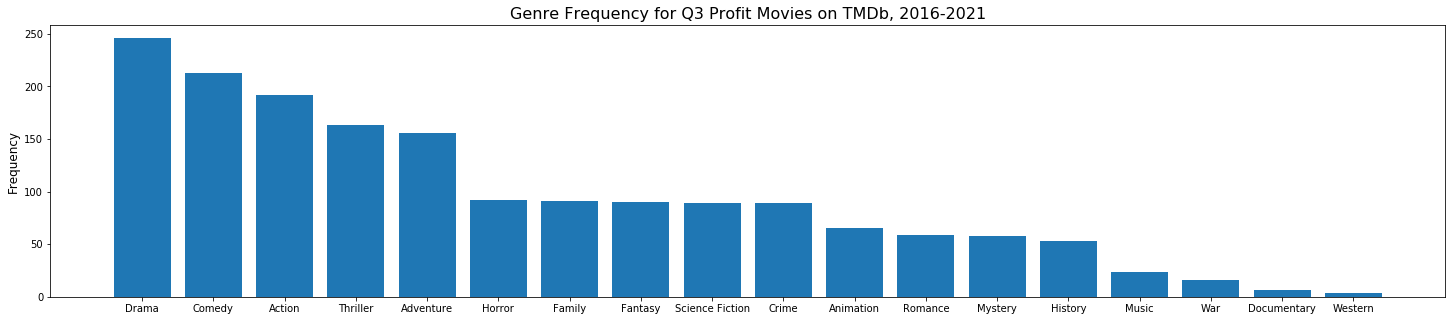

In [197]:
fig, ax = plt.subplots(figsize = (25,5))
ax.bar(transform_one_dim(df_q3["genre"]).value_counts().index,
        transform_one_dim(df_q3["genre"]).value_counts().values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Genre Frequency for Q3 Profit Movies on TMDb, 2016-2021", size = 16)


# Create Heat Map Visualization that shows the frequency of different combinations of Genre for Q3 Films:

In [140]:
def make_boolean_mask(p_series, u_series):
    # Instantiate Boolean Dictionary:
    bool_dict = {}
    # Loop through pandas Series containing unique categories (such as genre or production company):
    for counter, u_value in enumerate(u_series):
        # Build bool_dict with keys that are each unique category, and values that are a boolean for each items in each row of a pandas Series, such as genre
        bool_dict[u_value] = p_series.apply(lambda x: u_value in x)
    # Then, convert this dictionary to a data frame:
    return pd.DataFrame(bool_dict)


In [155]:
genre_boolean = make_boolean_mask(df_q3["genre"], unique_genres.keys()) # Using .keys() on a Pandas Series returns the index labels

In [156]:
genre_boolean[1:10]

,Drama,Comedy,Action,Thriller,Adventure,Horror,Family,Fantasy,Science Fiction,Crime,Animation,Romance,Mystery,History,Music,War,Documentary,Western
1,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False
2,False,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False
3,False,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False
4,True,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False
5,False,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False
6,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
8,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,True,False,True,False,False,True,True,True,False,False,False,False,False,False,False,False


In [161]:
# Correlate the incidence of genres occurring with each other:
corr_genres = genre_boolean.corr() # no need to specify the method, as pearson and spearman will return the same results.

In [158]:
corr_genres

,Drama,Comedy,Action,Thriller,Adventure,Horror,Family,Fantasy,Science Fiction,Crime,Animation,Romance,Mystery,History,Music,War,Documentary,Western
Drama,1.000000,-0.192113,-0.323362,-0.030735,-0.324235,-0.208537,-0.243266,-0.193336,-0.190387,0.037290,-0.242463,0.216239,0.005642,0.350913,0.073588,0.157427,-0.082481,0.015715
Comedy,-0.192113,1.000000,-0.158658,-0.359820,0.041541,-0.204877,0.319748,0.042919,-0.177907,-0.051044,0.348197,0.085026,-0.121562,-0.154050,0.116526,-0.077883,-0.073465,-0.059884
Action,-0.323362,-0.158658,1.000000,0.099449,0.232313,-0.159058,-0.166559,0.045180,0.338995,0.158723,-0.109527,-0.187306,-0.136727,-0.072340,-0.138006,0.042879,-0.067962,-0.011613
Thriller,-0.030735,-0.359820,0.099449,1.000000,-0.279791,0.407326,-0.254447,-0.158660,-0.061995,0.221736,-0.209826,-0.136068,0.258265,-0.042562,-0.103860,-0.030084,-0.060540,-0.049348
Adventure,-0.324235,0.041541,0.232313,-0.279791,1.000000,-0.185499,0.439461,0.380541,0.246487,-0.179835,0.381553,-0.129344,-0.114216,-0.155200,0.016095,-0.096770,-0.020655,0.045291
Horror,-0.208537,-0.204877,-0.159058,0.407326,-0.185499,1.000000,-0.164626,-0.034140,0.045596,-0.110256,-0.146368,-0.123175,0.331448,-0.130729,-0.085755,-0.040866,-0.042231,-0.034424
Family,-0.243266,0.319748,-0.166559,-0.254447,0.439461,-0.164626,1.000000,0.331240,-0.108840,-0.161025,0.735090,-0.106637,-0.120799,-0.129891,0.127925,-0.069097,-0.041960,-0.034203
Fantasy,-0.193336,0.042919,0.045180,-0.158660,0.380541,-0.034140,0.331240,1.000000,-0.028781,-0.146733,0.170348,-0.043004,-0.088305,-0.129050,0.081871,-0.068650,-0.041688,-0.033982
Science Fiction,-0.190387,-0.177907,0.338995,-0.061995,0.246487,0.045596,-0.108840,-0.028781,1.000000,-0.132315,-0.083298,-0.088842,-0.055515,-0.128207,-0.084101,-0.010058,-0.041416,-0.033760
Crime,0.037290,-0.051044,0.158723,0.221736,-0.179835,-0.110256,-0.161025,-0.146733,-0.132315,1.000000,-0.143545,-0.120286,0.102912,0.003778,-0.084101,-0.068202,-0.041416,0.023803


In [159]:
# What are the genres in Q3 movies that are most correlated with dramas?
corr_genres["Drama"].sort_values(ascending = False)

Drama              1.000000
History            0.350913
Romance            0.216239
War                0.157427
Music              0.073588
Crime              0.037290
Western            0.015715
Mystery            0.005642
Thriller          -0.030735
Documentary       -0.082481
Science Fiction   -0.190387
Comedy            -0.192113
Fantasy           -0.193336
Horror            -0.208537
Animation         -0.242463
Family            -0.243266
Action            -0.323362
Adventure         -0.324235
Name: Drama, dtype: float64

# How many times does a Genre occur with another Genre in a Given Movie?

In [167]:
# Convert Boolean Values to 0, 1:
bin_genres = genre_boolean.astype(int)
bin_genres.head(10)

,Drama,Comedy,Action,Thriller,Adventure,Horror,Family,Fantasy,Science Fiction,Crime,Animation,Romance,Mystery,History,Music,War,Documentary,Western
0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
6,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
8,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0


In [168]:
# Convert to an 18 * 18 matrix (number of different genres is 18), where each list in the matrix represents a genre (Drama, Comedy, etc in that order)
# And each item in a list represents the number of times that genre co-occurs with another genre.
genre_matrix = np.dot(bin_genres.T, bin_genres)

In [193]:
# For example, the first list in the matrix below represents the number of times Drama co-occurs with every other genre in the order of the columns:
# Drama with Drama, Drama with Comedy, Drama with Action, Drama with Thriller, and so on.
# Thus, it makes sense why the very first value in the first list is 246, because that's the total number of times Drama occurs
# The very last value in the very last list is 4, because that's the number of times Western occurs
genre_matrix

array([[246,  59,  33,  62,  21,  15,  11,  16,  16,  40,   4,  43,  24,
         51,  14,  14,   0,   2],
       [ 59, 213,  46,  11,  60,  11,  65,  36,  13,  26,  54,  28,  10,
          6,  15,   2,   0,   0],
       [ 33,  46, 192,  64,  78,  13,  12,  33,  62,  44,  11,   3,   7,
         11,   0,   7,   0,   1],
       [ 62,  11,  64, 163,   9,  64,   0,   9,  18,  45,   0,   5,  36,
         11,   1,   3,   0,   0],
       [ 21,  60,  78,   9, 156,   6,  65,  59,  46,   6,  48,   5,   6,
          2,   7,   0,   1,   2],
       [ 15,  11,  13,  64,   6,  92,   1,  11,  17,   5,   0,   1,  30,
          0,   0,   1,   0,   0],
       [ 11,  65,  12,   0,  65,   1,  91,  39,   5,   1,  59,   2,   1,
          0,   9,   0,   0,   0],
       [ 16,  36,  33,   9,  59,  11,  39,  90,  11,   2,  21,   6,   3,
          0,   7,   0,   0,   0],
       [ 16,  13,  62,  18,  46,  17,   5,  11,  89,   3,   4,   3,   5,
          0,   0,   2,   0,   0],
       [ 40,  26,  44,  45,   6,   5,

In [173]:
# Convert Matrix to DataFrame:
genre_frequency = pd.DataFrame(genre_matrix, columns = unique_genres.keys(), index = unique_genres.keys())

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text xticklabel objects>)

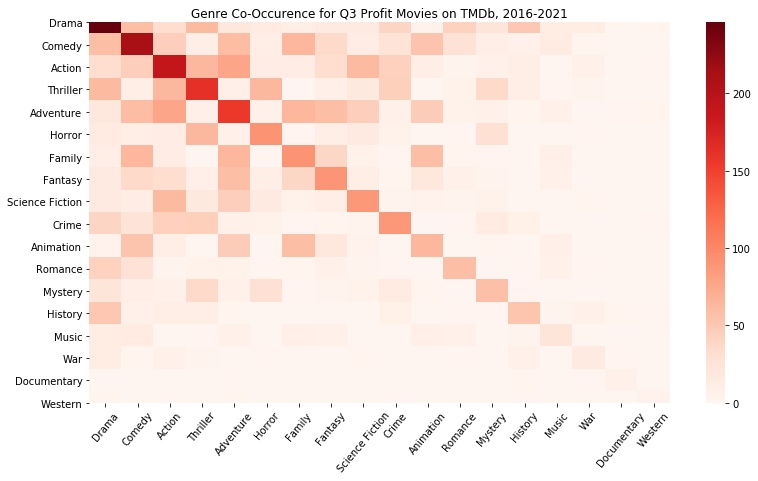

In [198]:
# Used seaborn to visualize the co-occurence of genres for Q3 Movies:
fig, ax = plt.subplots(figsize = (13,7))
sn.heatmap(genre_frequency, cmap = "Reds").set(title='Genre Co-Occurence for Q3 Profit Movies on TMDb, 2016-2021')
plt.xticks(rotation=50)
